<a href="https://colab.research.google.com/github/Karthik002/Spaceship-Titanic/blob/master/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
# load dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import roc_curve , auc
from sklearn.metrics import confusion_matrix , classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

# import data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
warnings.simplefilter(action='ignore')

In [58]:
# Drop null values
df_train['Age'] =df_train['Age'].fillna(df_train['Age'].median())
df_test['Age'] =df_test['Age'].fillna(df_test['Age'].median())
df_train['VIP'] =df_train['VIP'].fillna(False)
df_test['VIP'] =df_test['VIP'].fillna(False)
df_train['HomePlanet'] =df_train['HomePlanet'].fillna('Mars')
df_test['HomePlanet'] =df_test['HomePlanet'].fillna('Mars')
df_train['Destination']=df_train['Destination'].fillna("PSO J318.5-22")
df_test['Destination']=df_test['Destination'].fillna("PSO J318.5-22")
df_train['CryoSleep'] =df_train['CryoSleep'].fillna(False)
df_test['CryoSleep'] =df_test['CryoSleep'].fillna(False)
df_train['Cabin'] =df_train['Cabin'].fillna('T/0/P')
df_test['Cabin'] =df_test['Cabin'].fillna('T/0/P')
df_train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = df_train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0)
df_test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = df_test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0)


In [59]:
# Set index
df_train.set_index('PassengerId',inplace=True)
df_test.set_index('PassengerId',inplace=True)

# Split cabin column
df_train[['Deck','Num','Side']] = df_train.Cabin.str.split('/',expand=True)
df_test[['Deck','Num','Side']] = df_test.Cabin.str.split('/',expand=True)

# Process ages
df_train['AgeGroup'] = 0
for i in range(6):
    df_train.loc[(df_train.Age >= 10*i) & (df_train.Age < 10*(i + 1)), 'AgeGroup'] = i
df_test['AgeGroup'] = 0
for i in range(6):
    df_test.loc[(df_test.Age >= 10*i) & (df_test.Age < 10*(i + 1)), 'AgeGroup'] = i

# Encode categorical columns
categorical_cols= ['HomePlanet','CryoSleep','Destination','VIP','Deck','Side','Num']
for i in categorical_cols:
    le=LabelEncoder()
    arr=np.concatenate((df_train[i], df_test[i])).astype(str)
    le.fit(arr)
    df_train[i]=le.transform(df_train[i].astype(str))
    df_test[i]=le.transform(df_test[i].astype(str))

# Drop irrelevant columns
df_train= df_train.drop(['Name','Cabin'],axis=1)
df_test= df_test.drop(['Name','Cabin'],axis=1)
df_train['Transported']=df_train['Transported'].replace({True:1,False:0})
x = df_train.drop('Transported',axis=1)
y = df_train['Transported']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [60]:
# set parameters
params_clf = { 'n_estimators' : [50, 100, 200, 300, 400],
           'max_depth' : [4, 6, 8, 10, 12, 16],
           'min_samples_leaf' : [4, 8, 12, 16, 20],
           'min_samples_split' : [4, 8, 12, 16, 20]
         }

clf = RandomizedSearchCV(clf, param_distributions=params_clf, n_iter=30, scoring="roc_auc", n_jobs=-1)

# train model
clf.fit(x_train, y_train)

# model training & evaluation
model = RandomForestClassifier(n_estimators = 200, random_state=5, max_depth = 12, min_samples_leaf = 4, min_samples_split = 4, oob_score=True)

model.fit(x_train, y_train)

y_pred=model.predict(x_test)

print("train_set_accuracy: {:.3f}".format(model.score(x_train, y_train)) )
print("test_set_accuracy: {:.3f}".format(model.score(x_test, y_test)) )



train_set_accuracy: 0.868
test_set_accuracy: 0.802


Confusion matrix is 
 [[1017  286]
 [ 231 1074]]


Text(42.0, 0.5, 'predicted label')

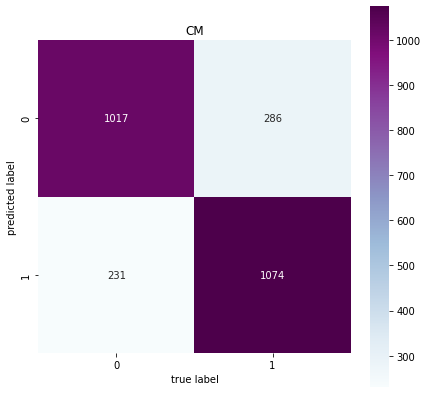

In [61]:
## confusion matrix
conf_mat=confusion_matrix(y_test,y_pred)
print("Confusion matrix is \n",conf_mat)

## plotting confusion matrix
plt.figure(figsize=(7,7))
plt.title("CM")
sns.heatmap(conf_mat, square=True,cmap="BuPu",annot=True,fmt='d')
plt.xlabel('true label')
plt.ylabel('predicted label')

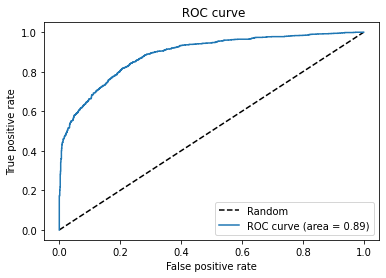

In [62]:
y_pred_proba = model.predict_proba(x_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc=auc(fpr,tpr)

#Now Draw ROC using fpr , tpr
plt.plot([0, 1], [0, 1], 'k--',label='Random')
plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' %roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(" ROC curve")
plt.legend(loc='best')